### 1) Setup & Initial Line Detection

For each `data/processed/{img_id}` folder, we:
1. Locate `cleaned.png` (and optionally the raw schematic).  
2. Create `line_results/` if needed.  
3. Binarize `cleaned.png` (wires white on black).  
4. Run `detect_lines()` with your parameters.  
5. Save `segments.json`.


In [32]:
# %%
import sys
from pathlib import Path
import cv2, numpy as np, json

# -- Define project and processed paths
proj       = Path.cwd().parent
processed  = proj / "data" / "processed"

# -- Collect all image directories once, so later cells can reuse `img_dirs`
img_dirs = [d for d in processed.iterdir() if d.is_dir()]

# -- Add your line-processing scripts to path
scripts_dir = proj / "line_processing" / "scripts"
sys.path.insert(0, str(scripts_dir))
from hough_detection import detect_lines

# -- Run Hough detection on each cleaned image
for img_dir in img_dirs:
    cleaned = img_dir / "cleaned.png"
    if not cleaned.exists():
        print(f"⚠️ {img_dir.name}: cleaned.png missing")
        continue

    lr = img_dir / "line_results"
    lr.mkdir(parents=True, exist_ok=True)

    img = cv2.imread(str(cleaned), cv2.IMREAD_GRAYSCALE)
    _, bin_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

    segs = detect_lines(
        bin_img,
        rho=1,
        theta=np.pi/180,
        threshold=50,
        min_line_length=15,
        max_line_gap=10
    )

    (lr / "segments.json").write_text(json.dumps(segs, indent=2))


### Random Sample of Raw Hough Overlays

Here we randomly pick five image folders, load their `segments.json`, draw the raw Hough lines (in red) on `cleaned.png`, and plot them for inspection.


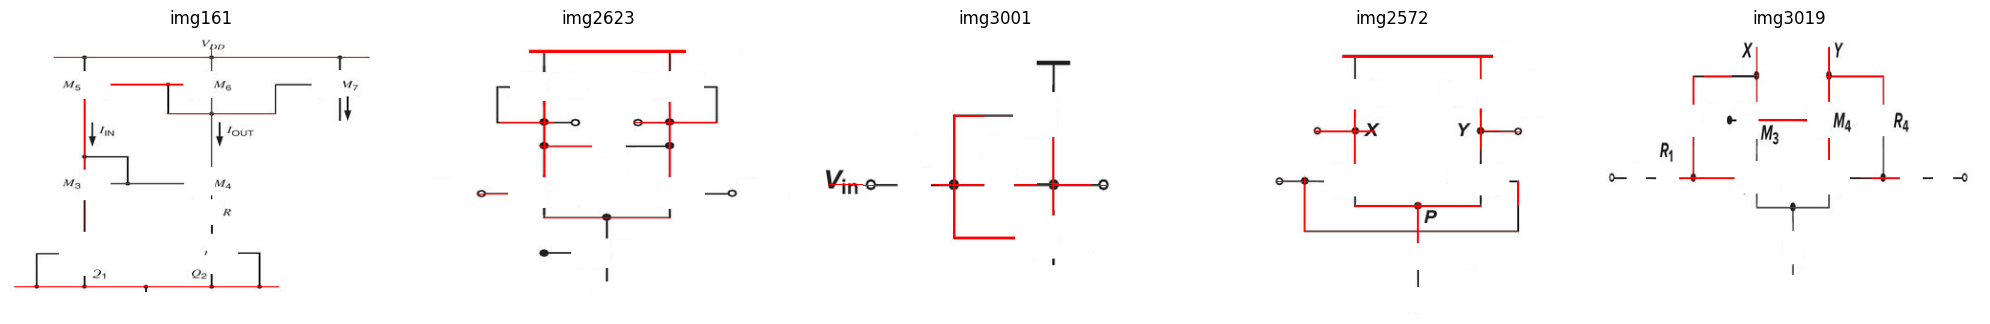

In [33]:
# %%
import random
import json
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Root of your processed data
processed_root = Path.cwd().parent / "data" / "processed"

# Gather all folders that have a segments.json
folders = []
for img_dir in processed_root.iterdir():
    seg_file = img_dir / "line_results" / "segments.json"
    if seg_file.exists():
        folders.append(img_dir)

# Randomly sample up to 5
sample_folders = random.sample(folders, min(5, len(folders)))

# Plot them
fig, axs = plt.subplots(1, len(sample_folders), figsize=(4 * len(sample_folders), 4))
if len(sample_folders) == 1:
    axs = [axs]

for ax, img_dir in zip(axs, sample_folders):
    # Load cleaned image
    clean = cv2.imread(str(img_dir / "cleaned.png"), cv2.IMREAD_GRAYSCALE)
    overlay = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)

    # Load segments
    with open(img_dir / "line_results" / "segments.json") as f:
        segments = json.load(f)
    # Draw raw Hough lines in red
    for x1, y1, x2, y2 in segments:
        cv2.line(overlay, (x1, y1), (x2, y2), (0, 0, 255), 1)

    # Convert BGR→RGB for matplotlib
    img_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(img_dir.name)
    ax.axis("off")

plt.tight_layout()
plt.show()


### 5) Split Segments by Orientation

We’ll use our new `split_by_orientation()` utility to classify and then color-code horizontals vs. verticals:
- **Blue** = horizontal  
- **Green** = vertical


In [34]:
# %%
from segment import split_by_orientation

# Split the already-detected `segments` into two lists
horizontals, verticals = split_by_orientation(segments, angle_thresh=45.0)

print(f"Found {len(horizontals)} horizontal and {len(verticals)} vertical segments.")

# Visualize: blue for horizontal, green for vertical
overlay_orient = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)
for x1, y1, x2, y2 in horizontals:
    cv2.line(overlay_orient, (x1, y1), (x2, y2), (255, 0, 0), 1)  # blue
for x1, y1, x2, y2 in verticals:
    cv2.line(overlay_orient, (x1, y1), (x2, y2), (0, 255, 0), 1)  # green



Found 9 horizontal and 9 vertical segments.


In [35]:
# %%
import json
import cv2
import matplotlib.pyplot as plt
from segment import split_by_orientation
from hough_detection import detect_lines

# Loop over each processed image folder
for img_dir in img_dirs:
    img_id = img_dir.name

    # 1) Identify cleaned.png and raw.png
    cleaned_path = img_dir / "cleaned.png"
    raw_cands    = [p for p in img_dir.glob("*.png") if p.name != "cleaned.png"]
    if raw_cands:
        raw_path = raw_cands[0]
    else:
        # fallback to data/raw/{img_id}.png
        fallback = project_root / "data" / "raw" / f"{img_id}.png"
        if fallback.exists():
            raw_path = fallback
        else:
            print(f"⚠️ {img_id}: no raw image, skipping")
            continue

    # 2) Load images
    clean = cv2.imread(str(cleaned_path), cv2.IMREAD_GRAYSCALE)
    raw   = cv2.imread(str(raw_path),   cv2.IMREAD_GRAYSCALE)

    # 3) Hough line detection
    _, binary = cv2.threshold(clean, 127, 255, cv2.THRESH_BINARY_INV)
    segments = detect_lines(
        binary, rho=1, theta=np.pi/180,
        threshold=50, min_line_length=15, max_line_gap=10
    )

    # 4) Split into horizontals/verticals
    horizontals, verticals = split_by_orientation(segments, angle_thresh=45.0)

    # 5) Create overlay image
    overlay = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)
    for x1,y1,x2,y2 in horizontals:
        cv2.line(overlay, (x1, y1), (x2, y2), (255, 0, 0), 1)
    for x1,y1,x2,y2 in verticals:
        cv2.line(overlay, (x1, y1), (x2, y2), (0, 255, 0), 1)

   

    # 7) Save results to disk
    results_dir = img_dir / "line_results"
    results_dir.mkdir(exist_ok=True)

    # Save segment lists
    with open(results_dir / "segments.json", "w") as f:
        json.dump(segments, f, indent=2)
    with open(results_dir / "horizontals.json", "w") as f:
        json.dump(horizontals, f, indent=2)
    with open(results_dir / "verticals.json", "w") as f:
        json.dump(verticals, f, indent=2)

    # Save overlay image
    cv2.imwrite(str(results_dir / "overlay.png"), overlay)

  



### Random Sample of 5 Overlays

Below we randomly select up to five `overlay.png` images from each `line_results` folder and display them side by side for quick inspection.


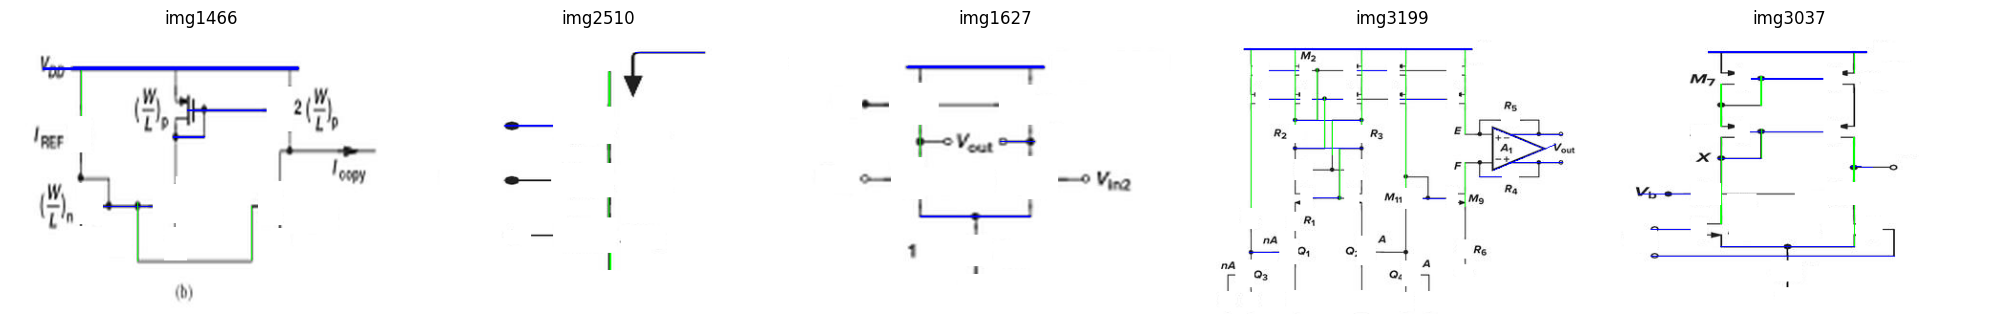

In [36]:
# %%
import random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# Root of your processed data
processed_root = Path.cwd().parent / "data" / "processed"

# Gather all overlay.png paths
overlay_paths = []
for img_dir in processed_root.iterdir():
    p = img_dir / "line_results" / "overlay.png"
    if p.exists():
        overlay_paths.append(p)

# Sample up to 5 overlays
sample_paths = random.sample(overlay_paths, min(5, len(overlay_paths)))

# Plot them
fig, axs = plt.subplots(1, len(sample_paths), figsize=(4 * len(sample_paths), 4))
if len(sample_paths) == 1:
    axs = [axs]

for ax, p in zip(axs, sample_paths):
    img = cv2.imread(str(p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(p.parent.parent.name)  # image ID as title
    ax.axis("off")

plt.tight_layout()
plt.show()


### 6) Compute Intersections → Node Candidates

We’ll import `segmented_intersections()` to find all crossing points between our horizontal and vertical segments.  
These points are candidate nodes (junctions) in the schematic.


In [37]:
# %%
import json
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from intersections import segmented_intersections

# Locate all processed image folders
processed_root = Path.cwd().parent / "data" / "processed"
img_dirs       = [d for d in processed_root.iterdir() if d.is_dir()]

for img_dir in img_dirs:
    lr = img_dir / "line_results"
    hfile = lr / "horizontals.json"
    vfile = lr / "verticals.json"
    if not (hfile.exists() and vfile.exists()):
        print(f"⚠️ Skipping {img_dir.name}: missing horizontals/verticals")
        continue

    # Load segment lists
    horizontals = json.loads(hfile.read_text())
    verticals   = json.loads(vfile.read_text())

    # Compute intersections
    nodes = segmented_intersections(horizontals, verticals)
    

    # Save intersections.json
    (lr / "intersections.json").write_text(json.dumps(nodes, indent=2))

    # Load cleaned image for overlay
    clean = cv2.imread(str(img_dir / "cleaned.png"), cv2.IMREAD_GRAYSCALE)
    overlay = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)
    for x, y in nodes:
        cv2.circle(overlay, (x, y), radius=3, color=(0, 255, 255), thickness=-1)

    # Save visualization
    cv2.imwrite(str(lr / "nodes.png"), overlay)
    


### Random Sample of 5 Intersection Visualizations

Below we randomly select up to five `nodes.png` images (yellow‐dot overlays) from each `line_results` folder and display them side by side.


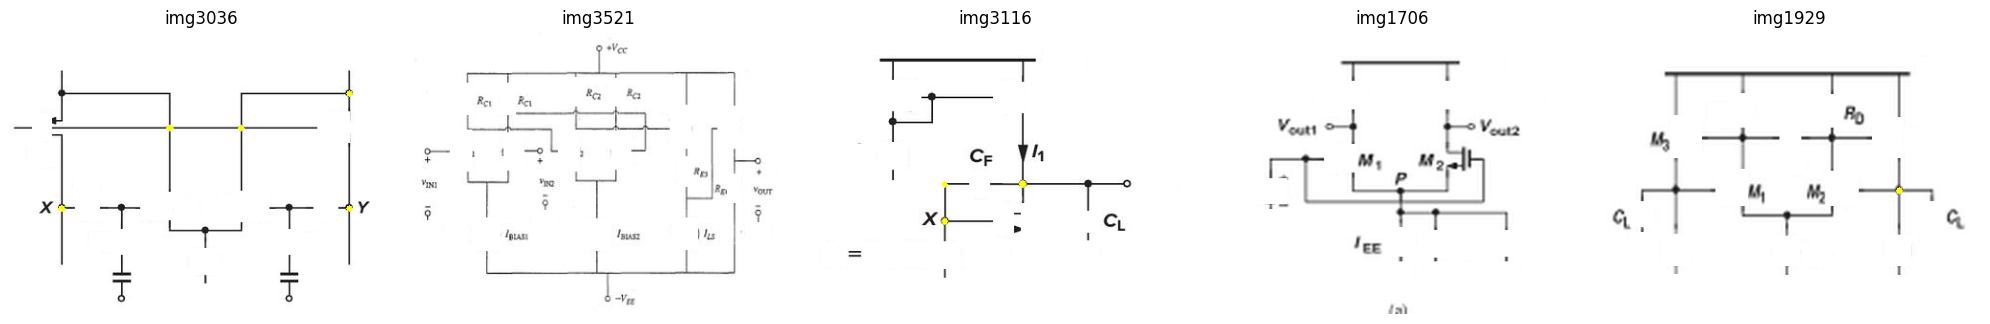

In [38]:
# %%
import random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# Root of your processed data
processed_root = Path.cwd().parent / "data" / "processed"

# Gather all nodes.png paths
nodes_paths = []
for img_dir in processed_root.iterdir():
    p = img_dir / "line_results" / "nodes.png"
    if p.exists():
        nodes_paths.append(p)

# Sample up to 5
sample_paths = random.sample(nodes_paths, min(5, len(nodes_paths)))

# Plot them
fig, axs = plt.subplots(1, len(sample_paths), figsize=(4 * len(sample_paths), 4))
if len(sample_paths) == 1:
    axs = [axs]

for ax, p in zip(axs, sample_paths):
    img = cv2.imread(str(p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(p.parent.parent.name)  # show the image ID
    ax.axis("off")

plt.tight_layout()
plt.show()


### 7) Cluster Intersection Points into True Nodes

We cluster any nearby intersection points (within 5 px) into consolidated nodes.  
This handles the case where some images have no intersections gracefully.


In [39]:
# %%
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from node_clustering import cluster_nodes

processed_root = Path.cwd().parent / "data" / "processed"
img_dirs       = [d for d in processed_root.iterdir() if d.is_dir()]

for img_dir in img_dirs:
    lr = img_dir / "line_results"
    inter_file = lr / "intersections.json"
    if not inter_file.exists():
        print(f"⚠️ Skipping {img_dir.name}: no intersections.json")
        continue

    # Load raw intersections
    raw_pts = json.loads(inter_file.read_text())
    if not raw_pts:
       
        clustered = []
    else:
        # Cluster them
        clustered = cluster_nodes(raw_pts, threshold=5.0)
        

    # Save clustered nodes
    (lr / "clustered_nodes.json").write_text(json.dumps(clustered, indent=2))

    # Visualize on the cleaned image
    clean = cv2.imread(str(img_dir / "cleaned.png"), cv2.IMREAD_GRAYSCALE)
    overlay = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)

    # Draw clustered nodes (magenta)
    for x, y in clustered:
        cv2.circle(overlay, (x, y), radius=4, color=(255, 0, 255), thickness=-1)

    # Save visualization
    cv2.imwrite(str(lr / "clustered_nodes.png"), overlay)
   


### Random Sample of 5 Clustered Node Overlays

Here we randomly select up to five `clustered_nodes.png` images (magenta‐dot overlays) from each `line_results` folder and display them side by side for quick inspection.


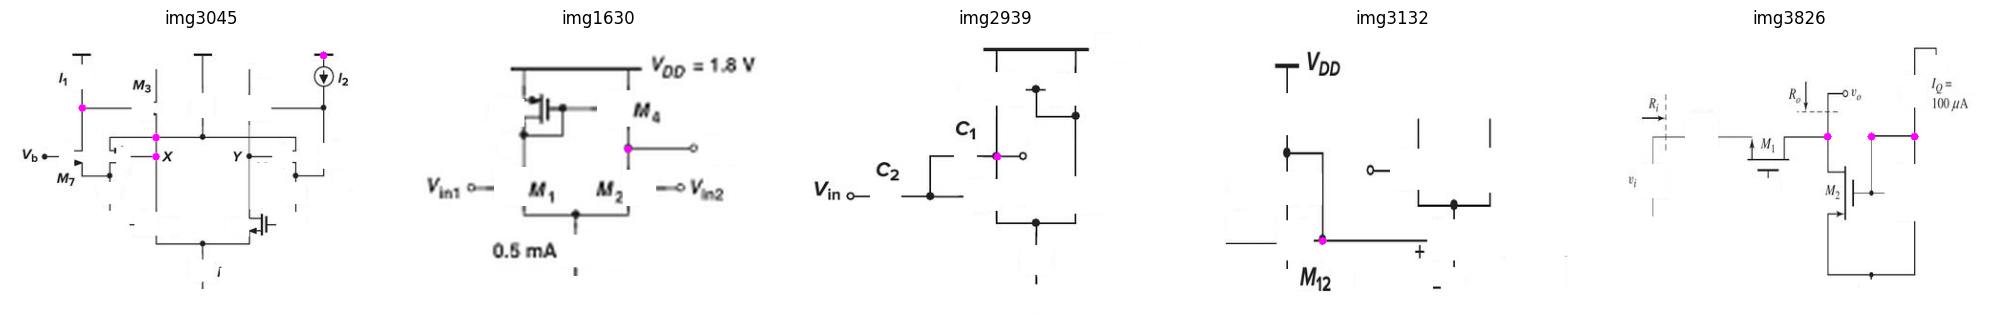

In [40]:
# %%
import random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# Root of your processed data
processed_root = Path.cwd().parent / "data" / "processed"

# Gather all clustered_nodes.png paths
clustered_paths = []
for img_dir in processed_root.iterdir():
    p = img_dir / "line_results" / "clustered_nodes.png"
    if p.exists():
        clustered_paths.append(p)

# Sample up to 5
sample_paths = random.sample(clustered_paths, min(5, len(clustered_paths)))

# Create subplots
fig, axs = plt.subplots(1, len(sample_paths), figsize=(4 * len(sample_paths), 4))
if len(sample_paths) == 1:
    axs = [axs]

# Plot each sampled overlay
for ax, p in zip(axs, sample_paths):
    img = cv2.imread(str(p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(p.parent.parent.name)  # image ID
    ax.axis("off")

plt.tight_layout()
plt.show()


### ▶️ 4) Detect Component Terminals

Load each image’s `cleaned.png` and `components.json`, detect pad centroids,
and save:
- **`comp_terminals.json`** — list of (x,y) terminals  
- **`terminals.png`**       — debug overlay (green dots) on cleaned image  


In [41]:
# %%
import json
import cv2
from pathlib import Path
from terminal_detection import detect_terminals_midpoint

project_root   = Path.cwd().parent
processed_root = project_root / "data" / "processed"

for img_dir in processed_root.iterdir():
    if not img_dir.is_dir(): 
        continue
    img_id     = img_dir.name
    lr         = img_dir / "line_results"
    lr.mkdir(exist_ok=True, parents=True)

    cleaned    = cv2.imread(str(img_dir/"cleaned.png"), cv2.IMREAD_GRAYSCALE)
    comp_json  = img_dir / "components.json"
    if not comp_json.exists():
        continue

    terminals = detect_terminals_midpoint(cleaned, comp_json,
                                          wire_thresh_block=11,
                                          wire_thresh_C=2)
    

    (lr/"comp_terminals.json").write_text(json.dumps(terminals, indent=2))

    # debug overlay
    ov = cv2.cvtColor(cleaned, cv2.COLOR_GRAY2BGR)
    for x,y in terminals:
        cv2.circle(ov, (x,y), 4, (0,255,0), -1)
    cv2.imwrite(str(lr/"terminals_mid.png"), ov)


### 🔍 Random Sample of 5 Terminal Detections


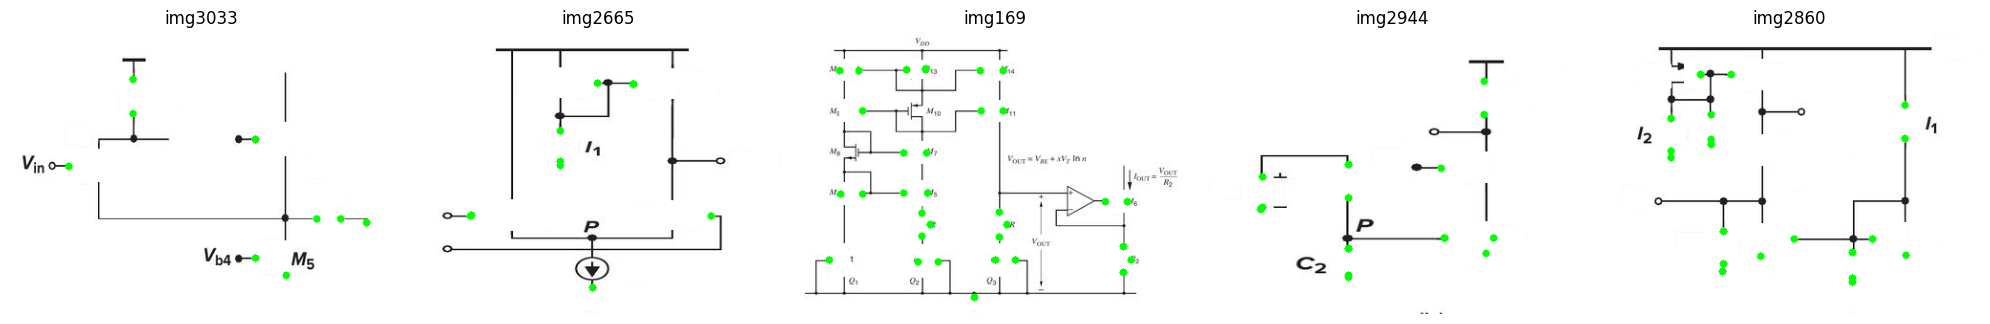

In [42]:
# %%
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

processed_root = Path.cwd().parent / "data" / "processed"

# collect all terminals.png paths
paths = [
    d/"line_results"/"terminals_mid.png"
    for d in processed_root.iterdir()
    if (d/"line_results"/"terminals_mid.png").exists()
]

sample = random.sample(paths, min(5, len(paths)))

fig, axs = plt.subplots(1, len(sample), figsize=(4*len(sample),4))
if len(sample)==1: axs=[axs]
for ax,p in zip(axs, sample):
    img = cv2.imread(str(p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(p.parent.parent.name)
    ax.axis("off")
plt.tight_layout()
plt.show()


## ▶️ Net Labeling (Mask + CC)

Build the wire mask, label connected‐components (nets), map each terminal to its net ID,  
and save the appropriate artifacts in `line_results/`.


In [43]:
# %%
import json
import cv2
from pathlib import Path
from net_labeling import make_wire_mask, label_nets, map_terminals_to_nets, save_net_overlays

project_root   = Path.cwd().parent
processed_root = project_root / "data" / "processed"

for img_dir in processed_root.iterdir():
    if not img_dir.is_dir():
        continue

    lr        = img_dir / "line_results"
    cleaned   = cv2.imread(str(img_dir/"cleaned.png"), cv2.IMREAD_GRAYSCALE)
    terminals = json.loads((lr/"comp_terminals.json").read_text())

    # 1) make mask & save wire_mask.png, nets_colored.png
    mask = make_wire_mask(cleaned, block_size=11, C=2)
    label_img, num_nets = label_nets(mask)
    save_net_overlays(img_dir, mask, label_img)
    

    # 2) map terminals → net IDs and save terminal_net_map.json
    term2net = map_terminals_to_nets(terminals, label_img)
    (lr/"terminal_net_map.json").write_text(json.dumps(term2net, indent=2))


### 🔍 Random Sample of 5 Wire Masks & Colored Nets


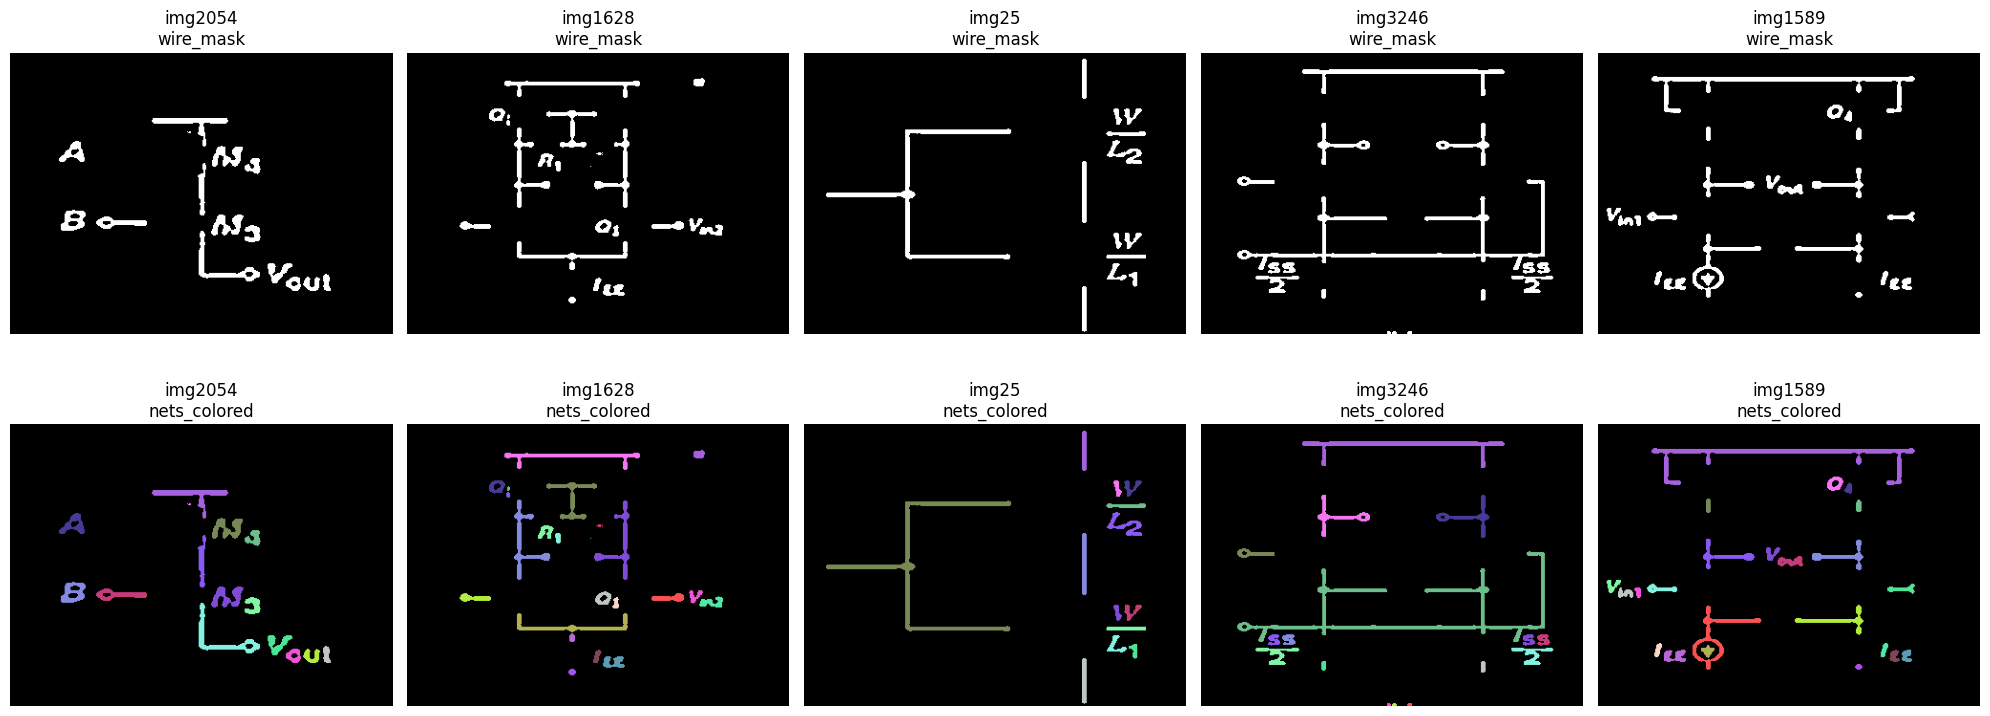

In [44]:
# %%
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

processed_root = Path.cwd().parent / "data" / "processed"
img_dirs = [d for d in processed_root.iterdir() if d.is_dir()]

# sample up to 5 folders that have nets_colored.png
candidates = [
    d for d in img_dirs
    if (d/"line_results"/"wire_mask.png").exists() and (d/"line_results"/"nets_colored.png").exists()
]
sample = random.sample(candidates, min(5, len(candidates)))

fig, axes = plt.subplots(2, len(sample), figsize=(4*len(sample), 8))
if len(sample) == 1:
    axes = [[axes[0]], [axes[1]]]

for col, img_dir in enumerate(sample):
    wm_path = img_dir/"line_results"/"wire_mask.png"
    nc_path = img_dir/"line_results"/"nets_colored.png"

    wm = cv2.imread(str(wm_path), cv2.IMREAD_GRAYSCALE)
    nc = cv2.cvtColor(cv2.imread(str(nc_path)), cv2.COLOR_BGR2RGB)

    ax1 = axes[0][col]
    ax1.imshow(wm, cmap="gray")
    ax1.set_title(f"{img_dir.name}\nwire_mask")
    ax1.axis("off")

    ax2 = axes[1][col]
    ax2.imshow(nc)
    ax2.set_title(f"{img_dir.name}\nnets_colored")
    ax2.axis("off")

plt.tight_layout()
plt.show()


## ▶️ Component-Pin Mapping (Side‐Aware)

Take the already‐computed `terminal_net_map.json` and your component bboxes  
and assign each terminal to its component edge (top/bottom/left/right) within a small tol.  
We save `component_net_map.json` plus a debug `mapping.png`.


In [45]:
# %%
import json
import cv2
from pathlib import Path
from component_mapping import map_terminals_to_components, save_component_net_map

project_root   = Path.cwd().parent
processed_root = project_root / "data" / "processed"

for img_dir in processed_root.iterdir():
    if not img_dir.is_dir():
        continue

    lr         = img_dir / "line_results"
    cleaned    = img_dir / "cleaned.png"
    comp_defs  = json.loads((img_dir/"components.json").read_text())
    terminals  = json.loads((lr/"comp_terminals.json").read_text())
    term2net   = json.loads((lr/"terminal_net_map.json").read_text())

    # 1) build the component_pin_map
    comp_net_map = map_terminals_to_components(comp_defs, terminals, term2net, tol=3)
    

    # 2) save JSON + overlay
    save_component_net_map(img_dir, comp_net_map, cleaned)


### 🔍 Random Sample of 5 Component→Net Mappings


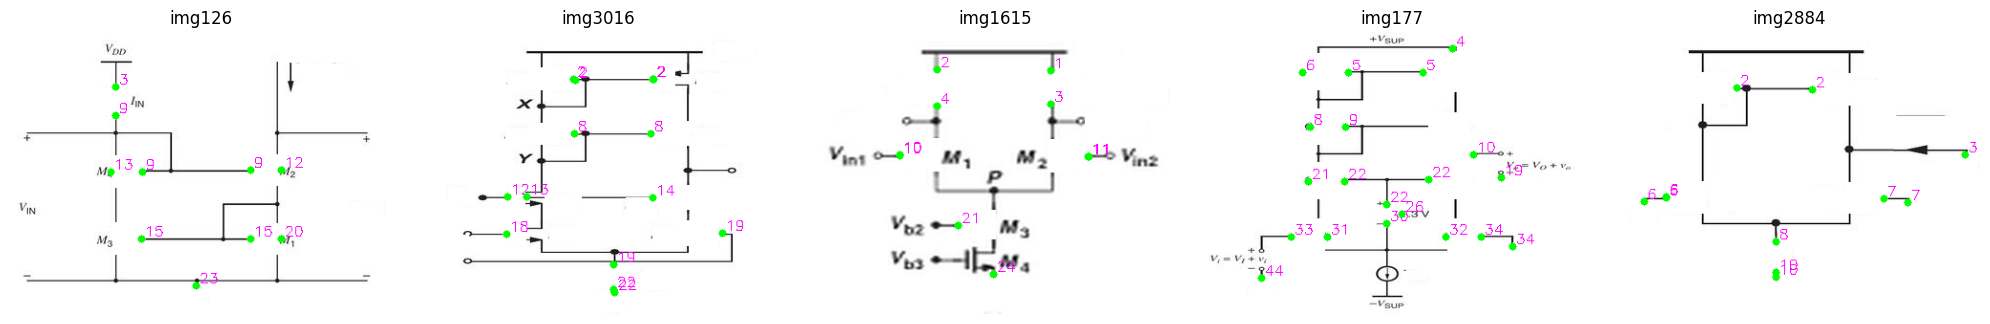

In [46]:
# %%
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

processed_root = Path.cwd().parent / "data" / "processed"
img_dirs = [d for d in processed_root.iterdir() if d.is_dir()]

# sample up to 5 folders that have mapping.png
candidates = [d for d in img_dirs if (d/"line_results"/"mapping.png").exists()]
sample = random.sample(candidates, min(5, len(candidates)))

fig, axes = plt.subplots(1, len(sample), figsize=(4*len(sample), 4))
if len(sample) == 1:
    axes = [axes]

for ax, img_dir in zip(axes, sample):
    mp = img_dir/"line_results"/"mapping.png"
    img = cv2.cvtColor(cv2.imread(str(mp)), cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(img_dir.name)
    ax.axis("off")

plt.tight_layout()
plt.show()


## ▶️ 12) Build & Export Netlist

Read each `component_net_map.json`, group pins by `net_id`, and write out:
- `netlist.txt` in `line_results/`  
  Format:  


In [47]:
# %%
import json
from pathlib import Path

project_root   = Path.cwd().parent
processed_root = project_root / "data" / "processed"

for img_dir in processed_root.iterdir():
    if not img_dir.is_dir():
        continue

    lr = img_dir / "line_results"
    cmap_f = lr / "component_net_map.json"
    if not cmap_f.exists():
        print(f"⚠️ {img_dir.name}: no component_net_map.json, skipping")
        continue

    comp_map = json.loads(cmap_f.read_text())
    # group pins by net
    nets = {}
    for entry in comp_map:
        nid   = entry["net_id"]
        comp  = entry["component"]
        pin   = entry["pin_index"]
        label = f"{comp}.pin{pin}"
        nets.setdefault(nid, []).append(label)

    # write netlist.txt
    out = lr / "netlist.txt"
    with open(out, "w") as f:
        for nid, pins in sorted(nets.items()):
            pins_str = ", ".join(pins)
            f.write(f"NET{nid}: {pins_str}\n")

    print(f"→ {img_dir.name}: wrote netlist.txt with {len(nets)} nets")


→ img6301: wrote netlist.txt with 1 nets
→ img2331: wrote netlist.txt with 4 nets
→ img184: wrote netlist.txt with 8 nets
→ img3826: wrote netlist.txt with 8 nets
→ img2336: wrote netlist.txt with 8 nets
→ img148: wrote netlist.txt with 3 nets
→ img3022: wrote netlist.txt with 5 nets
→ img177: wrote netlist.txt with 16 nets
→ img3821: wrote netlist.txt with 5 nets
→ img3479: wrote netlist.txt with 4 nets
→ img183: wrote netlist.txt with 5 nets
→ img1929: wrote netlist.txt with 11 nets
→ img1788: wrote netlist.txt with 22 nets
→ img3477: wrote netlist.txt with 4 nets
→ img179: wrote netlist.txt with 7 nets
→ img146: wrote netlist.txt with 11 nets
→ img112: wrote netlist.txt with 4 nets
→ img3047: wrote netlist.txt with 6 nets
→ img2353: wrote netlist.txt with 0 nets
→ img547: wrote netlist.txt with 5 nets
→ img3082: wrote netlist.txt with 5 nets
→ img124: wrote netlist.txt with 6 nets
→ img3071: wrote netlist.txt with 11 nets
→ img178: wrote netlist.txt with 4 nets
→ img147: wrote netli

### 🔍 Random Sample of 5 Netlist Files


In [48]:
# %%
import random
from pathlib import Path
import pprint

processed_root = Path.cwd().parent / "data" / "processed"
folders = [d for d in processed_root.iterdir() if (d/"line_results"/"netlist.txt").exists()]
sample = random.sample(folders, min(1, len(folders)))

for img_dir in sample:
    print(f"\n--- {img_dir.name} ---")
    print(Path(img_dir/"line_results"/"netlist.txt").read_text())



--- img178 ---
NET7: BJT.pin2, BJT.pin3
NET8: BJT.pin2
NET9: Ground.pin0
NET10: Ground.pin0

